# To Do List
* [v] Print dev loss
* [v] Print dev accuracy
* [v] Print -> Tensorboard
  * Loss and accuracy of the training, developement, and test sets
* [v] Save models
  * Naming: yyyymmddhhss-{fnn|cnn|rnn}-{sigm|tanh|relu}-{layer1}-{layer2}-{...}-{Optimizer}-lr{learning-rate}-bs{batch_size}
  * Saved models should have hyperparameters in their name
  * Hyperparameters to show
    * {fnn, cnn, rnn}, hidden activation, #layers, #layer_sizes, 
* [] Print out addition results with binary and decimal formats
  * (binary) 0001 + 1001 = 1010
  * (decimal) 1 + 9 = 10
* [] Reduce the number of the first hidden units from 256, which has 99.9% dev/test accuarcy. 
  * Use binary segmenting search. 256 >> 128 >> 192 >> ...
* [] Consider to assign 100% of the data to the training set.
  * And evaluate accuracy of the 
  

In [1]:
import tensorflow as tf
import numpy as np
import utils
from datetime import datetime
import matplotlib.pyplot as plt

%matplotlib inline

# 1. Import data

In [2]:
operator = 'add'
(input_train, input_dev, input_test, 
           target_train, target_dev, target_test) = utils.import_data(operator)

In [3]:
# If the training dataset takes all examples, then the dev and test datasets are the same as the training one. 
if input_dev.shape[0] == 0:
    input_dev = input_train
    target_dev = target_train
    input_test = input_train
    target_test = target_train

In [4]:
print(input_train.shape)
print(input_dev.shape)
print(input_test.shape)
print(target_train.shape)
print(target_dev.shape)
print(target_test.shape)

(65536, 16)
(65536, 16)
(65536, 16)
(65536, 9)
(65536, 9)
(65536, 9)


## 1.1 Hyperparameters

1. Break down the training set with the defined batch size.
2. Give away the last batch if it does not have the batch size.
3. Start a new epoch.
4. Shuffle the training set.

In [5]:
dir_saved_models = 'saved_models'
rootdir_logs = 'tf_logs'
train_print_period = 100
dev_print_period = 1000

# Contants
INPUT_DIM = input_train.shape[1] 
OUTPUT_DIM = target_train.shape[1]

# Hyperparameters - training
batch_size = 32
n_epoch = 999999999999
str_optimizer = 'adam'
learning_rate = 0.001
all_correct_stop = False
full_batch_saturation = True
if full_batch_saturation:
    all_correct_stop = False

# Hyperparameters - model
nn_model_type = 'mlp' # mlp, cnn, rnn
activation = tf.nn.sigmoid
h_layer_dims = [32] # h_layer_dims[0]: dim of h1 layer
last_size = OUTPUT_DIM

# Variables determined by other variables
train_size = input_train.shape[0]
n_batch = train_size // batch_size

In [6]:
n_bit_input_number = INPUT_DIM // 2

# 2. Define a computational graph for the feedforward neural net

In [7]:
inputs = tf.placeholder(tf.float32, shape=(None, input_train.shape[1]), name='inputs') # None for mini-batch size
targets = tf.placeholder(tf.float32, shape=(None, target_train.shape[1]), name='targets')

training_epoch = tf.placeholder(tf.float32, shape=None, name='training_epoch') 
full_batch_training = tf.placeholder(tf.int8, shape=None)

# Weight initialization
if activation == tf.nn.relu:
    kernel_initializer = tf.contrib.layers.variance_scaling_initializer(factor=2.0)
if activation == tf.nn.sigmoid:
    kernel_initializer = tf.contrib.layers.variance_scaling_initializer(factor=1.0)
if activation == tf.nn.tanh:
    kernel_initializer = tf.contrib.layers.variance_scaling_initializer(factor=1.0)
    
# NN structure
h1 = tf.layers.dense(inputs, h_layer_dims[0], activation=activation, kernel_initializer=kernel_initializer, name='h1')
last_logits = tf.layers.dense(h1, last_size, activation=None, kernel_initializer=kernel_initializer, name='last_logits')
sigmoid_outputs = tf.sigmoid(last_logits)
predictions = utils.tf_tlu(sigmoid_outputs)

# Loss: objective function
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets, logits=last_logits) # https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits
loss = tf.reduce_mean(loss)

# Accuracy
(accuracy, n_wrong, n_correct) = utils.get_measures(targets, predictions)

# Training, optimization
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
init = tf.global_variables_initializer()

Instructions for updating:
Use the retry module or similar alternatives.


# 3. Analyzing the weights and biases

## 3.1. Save the weight and bias

In [8]:
tf.all_variables()

Instructions for updating:
Please use tf.global_variables instead.


[<tf.Variable 'h1/kernel:0' shape=(16, 32) dtype=float32_ref>,
 <tf.Variable 'h1/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'last_logits/kernel:0' shape=(32, 9) dtype=float32_ref>,
 <tf.Variable 'last_logits/bias:0' shape=(9,) dtype=float32_ref>,
 <tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'h1/kernel/Adam:0' shape=(16, 32) dtype=float32_ref>,
 <tf.Variable 'h1/kernel/Adam_1:0' shape=(16, 32) dtype=float32_ref>,
 <tf.Variable 'h1/bias/Adam:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'h1/bias/Adam_1:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'last_logits/kernel/Adam:0' shape=(32, 9) dtype=float32_ref>,
 <tf.Variable 'last_logits/kernel/Adam_1:0' shape=(32, 9) dtype=float32_ref>,
 <tf.Variable 'last_logits/bias/Adam:0' shape=(9,) dtype=float32_ref>,
 <tf.Variable 'last_logits/bias/Adam_1:0' shape=(9,) dtype=float32_ref>]

In [9]:
dir_saved_model = 'saved_models'
model_id = '20181001180511'
model_to_import = '{}/{}/{}/epoch3686-batch2047.ckpt'.format(
    operator, nn_model_type, model_id)

#saver = tf.train.import_meta_graph('{}/{}.meta'.format(dir_saved_model, model_to_import))
saver = tf.train.Saver()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [10]:
with tf.Session(config=config) as sess:
    saver.restore(sess, '{}/{}'.format(dir_saved_models, model_to_import))
    print("Model restored.")
    
    h1_kernel = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'h1/kernel:0')
    h1_bias  = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'h1/bias:0')
    last_logits_kernel = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'last_logits/kernel:0')
    last_logits_bias  = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'last_logits/bias:0')
    
    [[h1_kernel_value], [h1_bias_value] ,[last_logits_kernel_value], [last_logits_bias_value]] = sess.run(
        [h1_kernel, h1_bias, last_logits_kernel, last_logits_bias])
    
    parameters = dict()
    parameters['h1/kernel'] = h1_kernel_value
    parameters['h1/bias'] = h1_bias_value
    parameters['last_logits/kernel'] = last_logits_kernel_value
    parameters['last_logits/bias'] = last_logits_bias_value

INFO:tensorflow:Restoring parameters from saved_models/add/mlp/20181001180511/epoch3686-batch2047.ckpt
Model restored.


In [11]:
import os 

def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [12]:
dir_to_save = 'data/add/parameters/{}'.format(model_id)
create_dir(dir_to_save)

import pickle

with open(dir_to_save + '/parameters.pickle', 'wb') as f: 
    pickle.dump(parameters, f)

## 3.2. Visualizing the weights and biases

### 3.2.1. Visualizing the weights and biases in the 1st layer

INFO:tensorflow:Restoring parameters from saved_models/add/mlp/20181001180511/epoch3686-batch2047.ckpt
Model restored.
(16, 32)
(1, 32)
(17, 32)


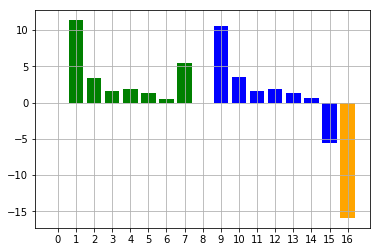

[0.23220591 1.0740265  0.994077   0.999999   0.99999887 0.99685055
 0.9443501  0.97363585]
0.90189296


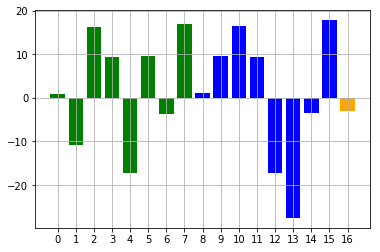

[0.73570436 1.1452659  0.9934707  0.9999997  1.         0.34810615
 1.0686038  0.9504083 ]
0.9051949


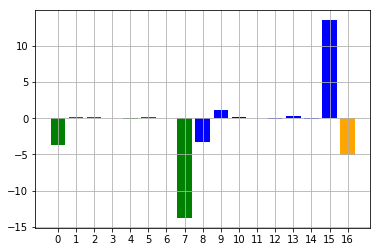

[1.1489139  0.19849393 1.3998758  0.99994624 0.9998389  0.52523893
 0.5706548  1.0166101 ]
0.85744655


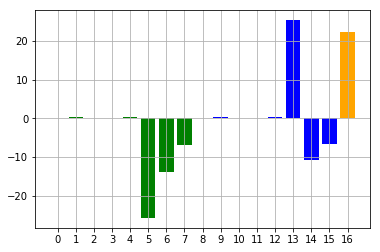

[0.19007002 0.8582263  6.701136   0.9999954  0.9999939  1.0156367
 1.2957786  1.0119604 ]
1.6340997


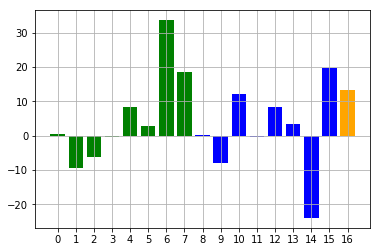

[4.231991   1.1888156  0.5172403  0.9999101  1.0000063  0.87693346
 1.4035604  0.9517248 ]
1.3962727


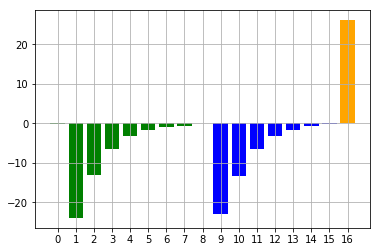

[3.0650437  1.0435764  0.99547935 0.9999999  0.99999994 0.99629706
 1.2975166  3.1516626 ]
1.568697


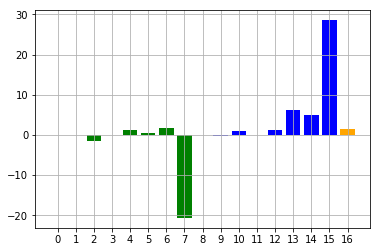

[0.48656943 0.51075643 1.3502132  0.99998474 0.99999475 0.07604267
 0.33393687 0.7228853 ]
0.6850479


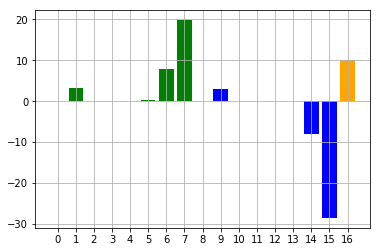

[14.366368    1.1052343   0.23429927  1.0000447   1.0000778   1.9742032
  0.98528206  0.6933582 ]
2.6698585


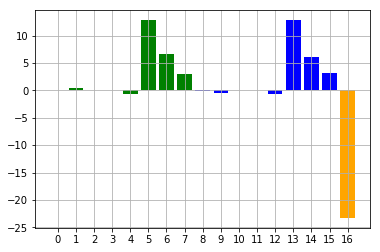

[0.877631   0.9684033  0.41230476 1.0000248  0.99999624 0.9987412
 1.0808573  0.9620681 ]
0.9125033


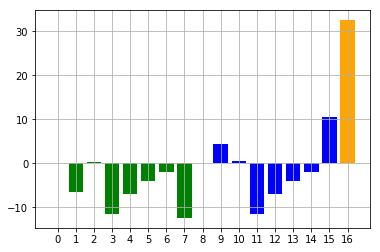

[17.157364    1.5028954   0.7745523   0.99999964  1.          0.9783816
  0.94295037  1.1879689 ]
3.068014


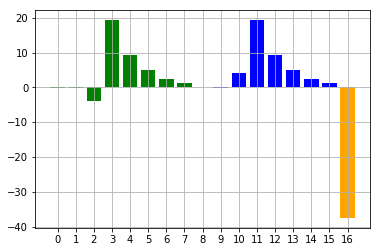

[1.949837   1.7540003  1.0046065  1.         1.         0.9934256
 1.0484415  0.90685856]
1.2071462


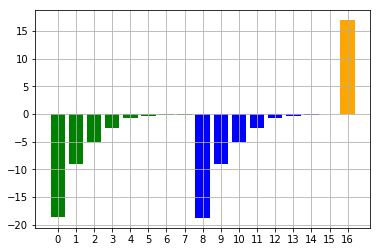

[ 0.99478257  0.9966883   1.0007329   0.99999964  1.0000014   0.9555181
  1.0450847  19.524584  ]
3.3146737


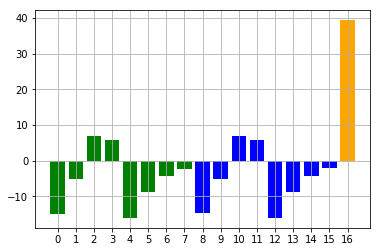

[1.031198   0.99596995 0.9964453  0.99999994 1.         0.99423313
 1.007184   1.0281259 ]
1.0066445


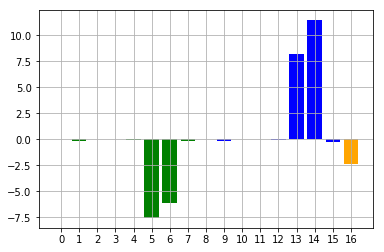

[1.1445067e+03 7.2362947e-01 2.6027834e+00 1.0000702e+00 9.9987054e-01
 9.2312694e-01 5.3697389e-01 6.3119888e-01]
143.99055


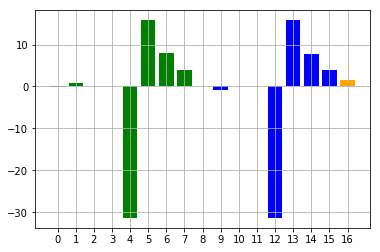

[9.768713   0.9756609  3.9103284  1.0000128  0.99999994 1.0009793
 1.0165958  1.0100262 ]
2.4602895


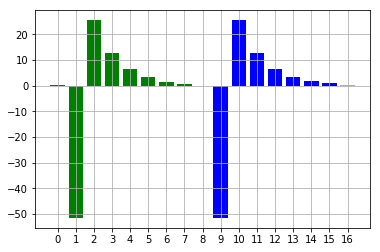

[1.1834192  0.997017   1.0014174  0.99999994 0.99999994 0.9879796
 0.97914225 0.46007866]
0.9511317


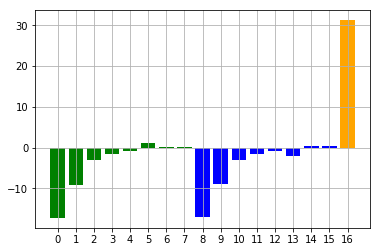

[1.0176395  1.0065542  0.9986093  0.99999994 0.99999994 0.5898175
 0.7533755  0.48176935]
0.85597074


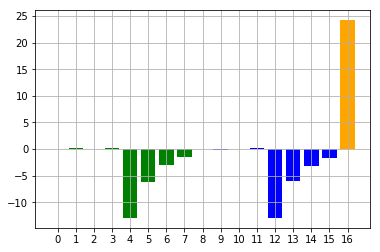

[2.6118035  1.4540398  0.1772281  1.000002   1.0000001  1.0044168
 0.95808893 0.9364869 ]
1.1427583


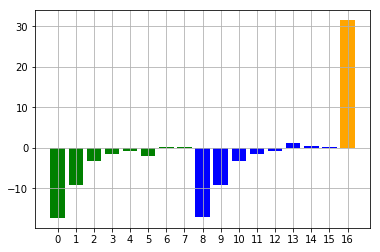

[1.0173937 1.0007241 0.9993857 0.9999999 1.0000011 1.7665715 0.7999173
 0.5416721]
1.0157082


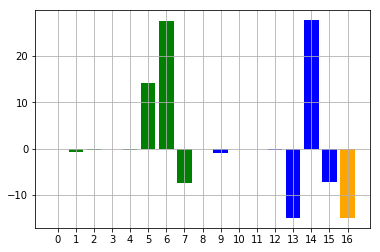

[4.3362594  0.81083626 3.8949466  0.9996628  1.0000085  0.94407856
 0.99447113 1.0262574 ]
1.7508152


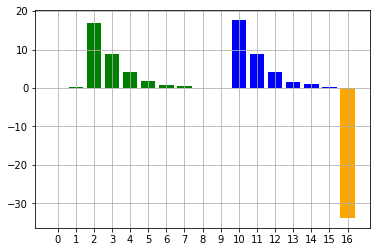

[2.2909026  2.2201664  0.96570086 1.         0.9999999  1.0259668
 0.86321896 2.7273457 ]
1.5116627


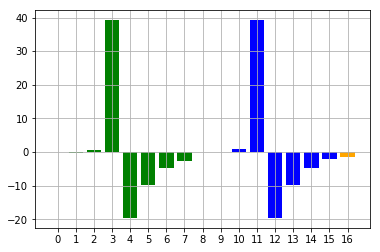

[0.01634928 2.9194279  0.6420148  1.         1.         1.0013462
 1.0040392  1.2794031 ]
1.1078225


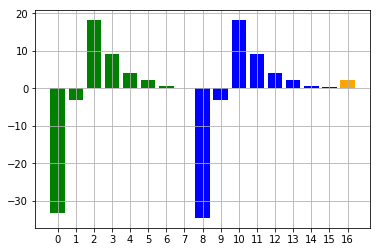

[0.96222275 0.99199384 0.99979013 1.0000004  1.         1.0050076
 0.962643   0.5254936 ]
0.93089396


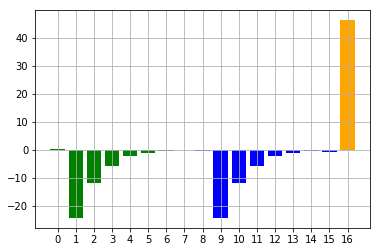

[1.1662053  0.9965433  1.000676   1.0000001  1.0000002  1.0166576
 0.9786042  0.10189766]
0.90757304


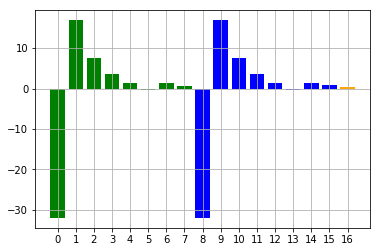

[1.0004498  0.99907833 0.99869114 0.99999994 1.0000002  1.0350559
 0.95844066 0.83261096]
0.9780409


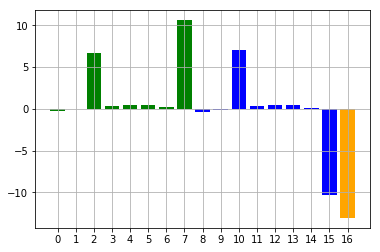

[0.6845411  0.02375132 0.94715285 0.9999993  0.9999986  1.0735345
 3.0614471  1.028456  ]
1.10236


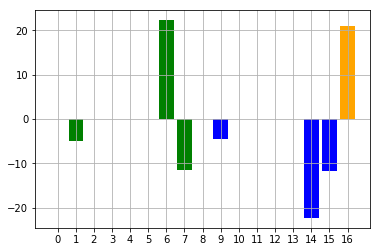

[0.61767477 1.054386   0.21198542 0.9999993  1.0000182  5.506323
 0.99996513 0.99736357]
1.4234644


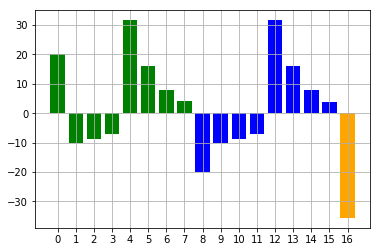

[1.0088514  1.0051702  0.99711156 1.0000008  0.9999998  0.99877274
 1.0004     1.125059  ]
1.0169207


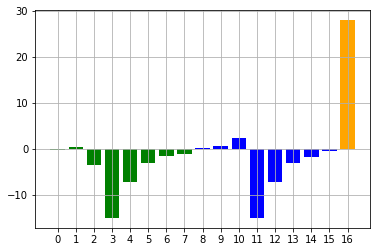

[0.6915086  0.6574218  1.4329157  1.         1.0000002  0.99621415
 0.8811204  2.0381784 ]
1.0871699


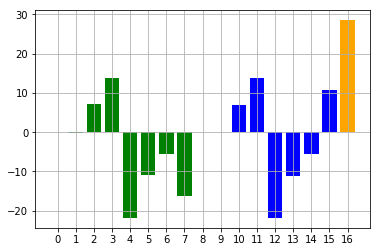

[0.28378764 3.637649   1.0450671  1.0000001  0.99999994 0.9927011
 1.013026   1.5159705 ]
1.3110251


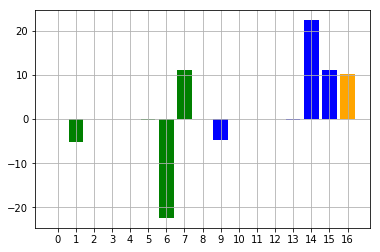

[2.3223958  1.107411   0.48183343 0.9999933  0.9999737  0.5725017
 0.99890435 1.0143601 ]
1.0621717


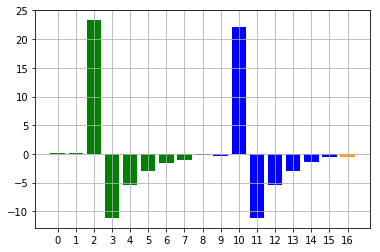

[1.0481453  0.21551263 1.0534213  1.         1.0000001  0.9916289
 1.0759708  2.1679704 ]
1.0690812
The mean of difference between weights on the same digits: 5.80634081736207


In [13]:
with tf.Session(config=config) as sess:
    saver.restore(sess, '{}/{}'.format(dir_saved_model, model_to_import))
    print("Model restored.")
    
    h1_kernel = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'h1/kernel:0')
    h1_bias  = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'h1/bias:0')
    
    [[h1_kernel_value], [h1_bias_value]] = sess.run(
        [h1_kernel, h1_bias],
        feed_dict={})
    
    h1_bias_value = h1_bias_value.reshape((1,h1_bias_value.shape[0]))
    h1_value = np.concatenate((h1_kernel_value, h1_bias_value), axis=0)
    
    print(h1_kernel_value.shape)
    print(h1_bias_value.shape)
    print(h1_value.shape)
    
    np_mean_array = np.zeros((h1_value.shape[1],))
    
    for i in range(h1_value.shape[1]):
        
        x = np.arange(h1_value.shape[0])
        y = np.squeeze(h1_value[:,i])
        #yticks = [0.05 * i for i in range(21)]
        
        mask1 = x < n_bit_input_number 
        mask2 = (x >= n_bit_input_number) * (x < n_bit_input_number * 2)
        mask3 = x >= n_bit_input_number * 2

        plt.bar(x[mask1], y[mask1], color = 'green')
        plt.bar(x[mask2], y[mask2], color = 'blue')
        plt.bar(x[mask3], y[mask3], color = 'orange')       
    
        plt.grid(True)
        plt.xticks(x)
        #plt.yticks(yticks)
        plt.show()
        
        n1_weights = y[:n_bit_input_number]
        n2_weights = y[n_bit_input_number:-1]
        print(np.absolute(n1_weights / n2_weights))
        m = np.mean(np.absolute(n1_weights / n2_weights))
        print(m)
        np_mean_array[i] = m
        
    print("The mean of difference between weights on the same digits: {}".format(np.mean(np_mean_array)))

### 3.2.2. Visualizing the weights and biases in the 2nd layer

INFO:tensorflow:Restoring parameters from saved_models/add/mlp/20181001180511/epoch3686-batch2047.ckpt
Model restored.
(32, 9)
(1, 9)
(33, 9)


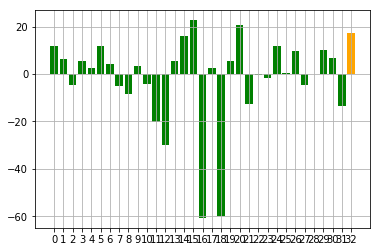

-51.04153596609831


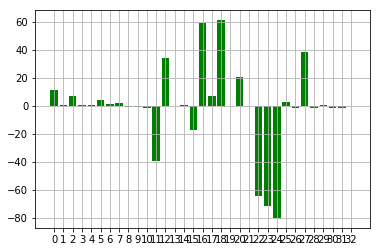

-28.92604462429881


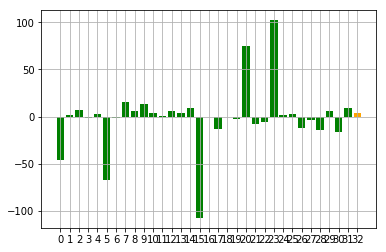

-29.02968856692314


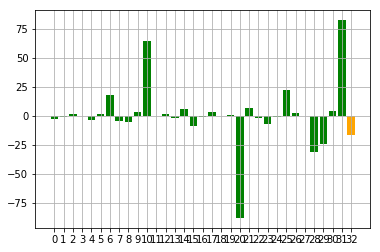

23.913131684064865


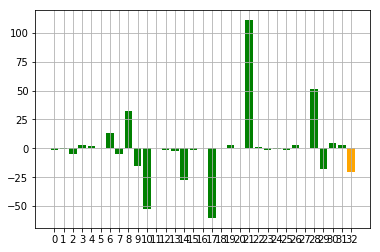

14.86829475313425


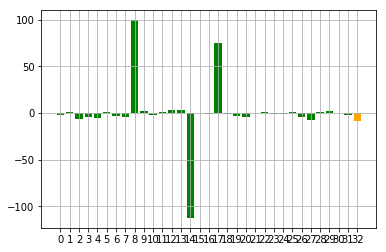

15.651021406054497


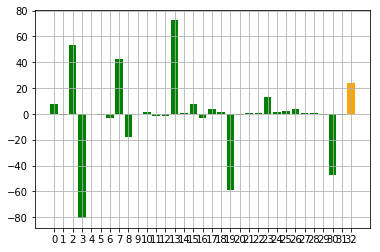

21.728828325867653


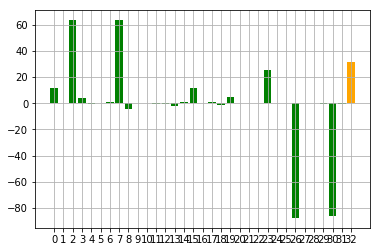

32.50102891260758


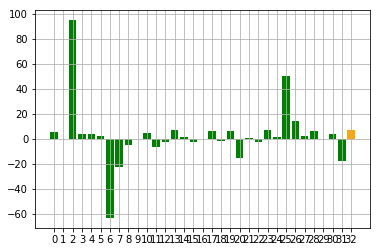

86.31435508653522


In [14]:
with tf.Session(config=config) as sess:
    saver.restore(sess, '{}/{}'.format(dir_saved_model, model_to_import))
    print("Model restored.")
    
    last_logits_kernel = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'last_logits/kernel:0')
    last_logits_bias  = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'last_logits/bias:0')
    
    [[last_logits_kernel_value], [last_logits_bias_value]] = sess.run(
        [last_logits_kernel, last_logits_bias],
        feed_dict={})
    
    last_logits_bias_value = last_logits_bias_value.reshape((1,last_logits_bias_value.shape[0]))
    last_logits_value = np.concatenate((last_logits_kernel_value, last_logits_bias_value), axis=0)
    
    print(last_logits_kernel_value.shape)
    print(last_logits_bias_value.shape)
    print(last_logits_value.shape)
    
    for i in range(last_logits_value.shape[1]):
        
        x = np.arange(last_logits_value.shape[0])
        y = np.squeeze(last_logits_value[:,i])
        #yticks = [0.05 * i for i in range(21)]
        
        mask1 = x < last_logits_kernel_value.shape[0]
        mask2 = x >= last_logits_kernel_value.shape[0]

        plt.bar(x[mask1], y[mask1], color = 'green')
        plt.bar(x[mask2], y[mask2], color = 'orange')       
    
        plt.grid(True)
        plt.xticks(x)
        #plt.yticks(yticks)
        plt.show()
        
        print(np.dot(y, np.ones_like(y, dtype=np.float)))